In [1]:
# Force single GPU prevents DataParallel wrapping in Kaggle T4 GPU X 2 which breaks lightning.gpu replication
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
!pip uninstall -y mamba-ssm causal-conv1d >/dev/null 2>&1 || true
!pip install -q torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 >/dev/null 2>&1
!pip install -q causal-conv1d==1.4.0 --no-build-isolation >/dev/null 2>&1
!pip install -q mamba-ssm==2.2.4 --no-build-isolation >/dev/null 2>&1
!pip install -q mambavision seaborn timm pillow >/dev/null 2>&1
!pip install -q "transformers>=4.43" "accelerate>=0.33" "datasets>=2.19" "evaluate>=0.4" "peft>=0.12.0" "scikit-learn>=1.3" "bitsandbytes>=0.43.0" >/dev/null 2>&1
!pip install -q pennylane pennylane-lightning pennylane-lightning[gpu] >/dev/null 2>&1

In [7]:
import warnings, random, numpy as np, time
warnings.filterwarnings("ignore")
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix, roc_auc_score, roc_curve
import torchvision.transforms as T
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, set_seed
from peft import LoraConfig, get_peft_model
import pennylane as qml
import time, json, os, math, psutil, gc
from collections import defaultdict
from sklearn.metrics import average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve

2025-11-02 09:32:41.707149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762075961.899748      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762075961.954929      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); set_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_NPZ_PATH = "/kaggle/input/mixedtype-wafer-defect-datasets/Wafer_Map_Datasets.npz"
LABEL_NAMES = ["Center","Donut","Edge_Loc","Edge_Ring","Loc","Near_Full","Scratch","Random"]
NUM_LABELS = len(LABEL_NAMES)
label2id = {n:i for i,n in enumerate(LABEL_NAMES)}
id2label = {i:n for n,i in label2id.items()}
MODEL_VARIANT = "quantum"

In [9]:
npz = np.load(DATA_NPZ_PATH, allow_pickle=True)
X = npz["arr_0"]; Y = npz["arr_1"].astype(np.float32)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=seed, shuffle=True)
X_val, X_test, Y_val, Y_test     = train_test_split(X_temp, Y_temp, test_size=2/3, random_state=seed, shuffle=True)
model_mean = [0.485, 0.456, 0.406]; model_std = [0.229, 0.224, 0.225]
train_transform = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=3),
    T.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(0.5),
    T.ToTensor(),
    T.Normalize(mean=model_mean, std=model_std),
])
val_transform = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=3),
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=model_mean, std=model_std),
])
class MixedWM38Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images; self.labels = labels
        self.transform = transform
    def __len__(self): return self.images.shape[0]
    def __getitem__(self, idx):
        img = self.images[idx]
        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)
        x = self.transform(img) if self.transform else img
        y = torch.from_numpy(self.labels[idx])
        return {"tensor": x, "labels": y}
def collate_fn(batch):
    tensor = torch.stack([b["tensor"] for b in batch])
    labels = torch.stack([b["labels"] for b in batch])
    return {"tensor": tensor, "labels": labels}
train_ds = MixedWM38Dataset(X_train, Y_train, transform=train_transform)
val_ds   = MixedWM38Dataset(X_val,   Y_val,   transform=val_transform)
test_ds  = MixedWM38Dataset(X_test,  Y_test,  transform=val_transform)

In [10]:
MODEL_NAME = "nvidia/MambaVision-B-21K"
core = AutoModelForImageClassification.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(device)
def replace_last_linear_with_identity(m):
    last_name, last_mod = None, None
    for n, mod in m.named_modules():
        if isinstance(mod, nn.Linear):
            last_name, last_mod = n, mod
    parent = m; parts = last_name.split(".")
    for p in parts[:-1]: parent = getattr(parent, p)
    in_features = last_mod.in_features
    setattr(parent, parts[-1], nn.Identity())
    return last_name, in_features
last_linear_name, feat_dim = replace_last_linear_with_identity(core)
for p in core.parameters():
    p.requires_grad = False

config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/768 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-B-21K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-B-21K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/391M [00:00<?, ?B/s]

In [11]:
n_qubits, n_layers = 4, 2
def make_pl_device(n_qubits: int):
    try:
        return qml.device("lightning.gpu", wires=n_qubits)
    except Exception:
        return qml.device("default.qubit", wires=n_qubits)
def make_quantum_head(in_dim, num_labels):
    n_qubits, n_layers = 4, 2
    try:
        dev = qml.device("lightning.gpu", wires=n_qubits)
    except Exception:
        try:
            dev = qml.device("lightning.qubit", wires=n_qubits)
        except Exception:
            dev = qml.device("default.qubit", wires=n_qubits)
    @qml.qnode(dev, interface="torch", diff_method="adjoint")
    def vqc(inputs, weights):
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
        qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    qlayer = qml.qnn.TorchLayer(vqc, weight_shapes)
    class Q4Head(nn.Module):
        def __init__(self, in_dim, num_labels):
            super().__init__()
            self.reduce = nn.Linear(in_dim, n_qubits)
            self.q = qlayer
            self.out = nn.Linear(n_qubits, num_labels)
        def forward(self, feats):
            angles = torch.tanh(self.reduce(feats)) * 1.57079632679
            qexp = self.q(angles)
            if qexp.device != angles.device:
                qexp = qexp.to(angles.device)
            return self.out(qexp)
    return Q4Head(in_dim, num_labels)

class MLPHead(nn.Module):
    def __init__(self, in_dim, num_labels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_labels)
        )
    def forward(self, feats):
        return self.net(feats)

head = make_quantum_head(feat_dim, NUM_LABELS) if MODEL_VARIANT=="quantum" else MLPHead(feat_dim, NUM_LABELS)
head.to(device)

Q4Head(
  (reduce): Linear(in_features=1024, out_features=4, bias=True)
  (q): <Quantum Torch Layer: func=vqc>
  (out): Linear(in_features=4, out_features=8, bias=True)
)

In [12]:
class HybridModel(nn.Module):
    def __init__(self, core, head):
        super().__init__()
        self.core = core
        self.head = head
    def forward(self, tensor=None, **kwargs):
        out = self.core(tensor=tensor, **kwargs)
        feats = out["logits"] if isinstance(out, dict) else (out.logits if hasattr(out, "logits") else out)
        logits = self.head(feats)
        return {"logits": logits}

model = HybridModel(core, head).to(device)

# Sanity check
tmp_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
xb = next(iter(tmp_loader))
with torch.inference_mode():
    yb = model(tensor=xb["tensor"].to(device))["logits"]
    print("Sanity:", xb["tensor"].shape, "->", yb.shape)

Sanity: torch.Size([2, 3, 224, 224]) -> torch.Size([2, 8])


In [13]:
from transformers import TrainerCallback
class LossRecorderCallback(TrainerCallback):
    def __init__(self): self.train_loss=[]; self.eval_loss=[]
    def on_log(self, args, state, control, logs=None, **kwargs):
        if not logs: return
        if "loss" in logs and "epoch" in logs: self.train_loss.append((logs["epoch"], logs["loss"]))
        if "eval_loss" in logs and "epoch" in logs: self.eval_loss.append((logs["epoch"], logs["eval_loss"]))
class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight=None, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        dev = labels.device if isinstance(labels, torch.Tensor) else next(model.parameters()).device
        labels = labels.to(dev).float()
        for k in list(inputs.keys()):
            if isinstance(inputs[k], torch.Tensor):
                inputs[k] = inputs[k].to(dev)
        outputs = model(**inputs)
        logits = outputs["logits"] if isinstance(outputs, dict) else (outputs.logits if hasattr(outputs,"logits") else outputs)
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss
def compute_metrics(eval_pred):
    logits, labels = (eval_pred if isinstance(eval_pred, tuple) else (eval_pred.predictions, eval_pred.label_ids))
    probs = 1/(1+np.exp(-logits)); pred = (probs>=0.5).astype(int)
    micro_f1 = f1_score(labels, pred, average="micro", zero_division=0)
    macro_f1 = f1_score(labels, pred, average="macro", zero_division=0)
    return {"micro_f1": micro_f1, "macro_f1": macro_f1}
pos = Y_train.sum(axis=0); neg = len(Y_train) - pos
pos_weight = torch.tensor((neg / np.maximum(pos, 1)).astype(np.float32)).to(device)

In [14]:
BATCH_SIZE, GRAD_ACCUM, LR = 32, 2, 5e-4
OUTPUT_DIR = f"out_{MODEL_VARIANT}_q4"
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    remove_unused_columns=False,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    learning_rate=LR,
    num_train_epochs=10,
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to="none",
    seed=seed,
    label_names=["labels"],
)
recorder = LossRecorderCallback()
trainer = MultiLabelTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    pos_weight=pos_weight,
    callbacks=[recorder],
)

In [15]:
train_result = trainer.train()
val_metrics = trainer.evaluate()
print("Validation metrics:", val_metrics)

Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,1.909500,0.936094,0.475011,0.375492
2,1.824900,0.851016,0.484012,0.421435
3,1.683800,0.811437,0.531610,0.498412
4,1.586800,0.778019,0.534911,0.514225
5,1.533500,0.763311,0.530838,0.517270
6,1.377600,0.750539,0.535103,0.530654
7,1.448900,0.739431,0.534596,0.532611
8,1.390000,0.729662,0.551487,0.552678
9,1.369500,0.732059,0.556627,0.556963
10,1.390300,0.730853,0.556955,0.558987


Validation metrics: {'eval_loss': 0.7308534979820251, 'eval_micro_f1': 0.5569546967723259, 'eval_macro_f1': 0.5589869179130269, 'eval_runtime': 23.4039, 'eval_samples_per_second': 162.409, 'eval_steps_per_second': 5.085, 'epoch': 10.0}


In [16]:
def sigmoid_np(x): return 1/(1+np.exp(-x))
val_pred   = trainer.predict(val_ds)
val_logits = val_pred.predictions; val_labels = val_pred.label_ids
val_probs  = sigmoid_np(val_logits)
def tune_thresholds(probs, labels):
    ths = []
    for c in range(labels.shape[1]):
        s = probs[:,c]; best_t=0.5; best_f1=-1
        for t in np.linspace(0.05, 0.95, 19):
            f1 = f1_score(labels[:,c], (s>=t).astype(int), average="binary", zero_division=0)
            if f1>best_f1: best_f1=f1; best_t=t
        ths.append(best_t)
    return np.array(ths)
thresholds = tune_thresholds(val_probs, val_labels)
test_pred   = trainer.predict(test_ds)
test_logits = test_pred.predictions; test_labels = test_pred.label_ids
test_probs  = sigmoid_np(test_logits)
test_preds_tuned = (test_probs >= thresholds[None,:]).astype(int)

print(f"Per-class classification report (test @tuned) [{MODEL_VARIANT}]")
print(classification_report(test_labels, test_preds_tuned, target_names=LABEL_NAMES, zero_division=0))

Per-class classification report (test @tuned) [quantum]
              precision    recall  f1-score   support

      Center       0.98      0.58      0.73      2613
       Donut       0.96      0.82      0.89      2355
    Edge_Loc       0.35      1.00      0.52      2586
   Edge_Ring       0.33      0.99      0.49      2407
         Loc       0.48      0.96      0.64      3595
   Near_Full       0.09      0.57      0.15        30
     Scratch       0.51      1.00      0.67      3753
      Random       0.88      0.97      0.93       180

   micro avg       0.48      0.90      0.62     17519
   macro avg       0.57      0.86      0.63     17519
weighted avg       0.59      0.90      0.66     17519
 samples avg       0.47      0.88      0.59     17519



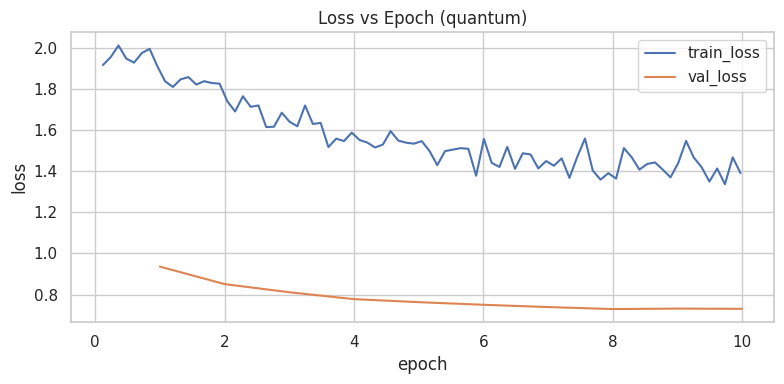

In [17]:
# Loss vs epoch
sns.set(style="whitegrid")
plt.figure(figsize=(8,4))
if len(recorder.train_loss)>0:
    tr_epochs, tr_losses = zip(*recorder.train_loss)
    plt.plot(tr_epochs, tr_losses, label="train_loss")
if len(recorder.eval_loss)>0:
    ev_epochs, ev_losses = zip(*recorder.eval_loss)
    plt.plot(ev_epochs, ev_losses, label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.title(f"Loss vs Epoch ({MODEL_VARIANT})"); plt.tight_layout(); plt.show()

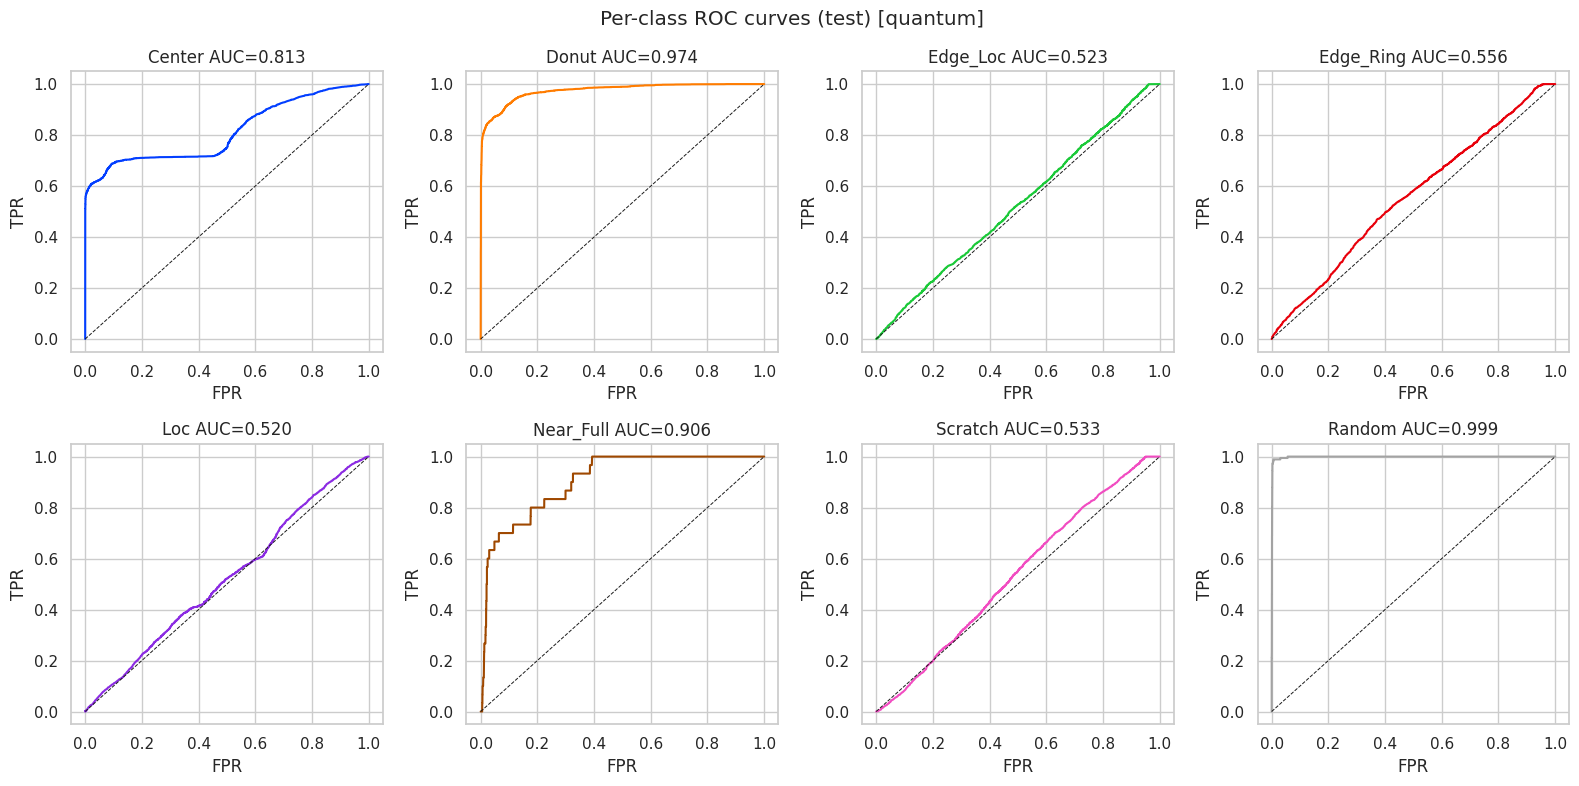

In [18]:
# ROC curves
fig, axes = plt.subplots(2, 4, figsize=(16,8)); axes = axes.ravel()
palette = sns.color_palette("bright", 8)
for c in range(NUM_LABELS):
    try:
        fpr, tpr, _ = roc_curve(test_labels[:,c], test_probs[:,c])
        axes[c].plot(fpr, tpr, color=palette[c])
        axes[c].plot([0,1],[0,1],'k--', linewidth=0.7)
        auc_c = roc_auc_score(test_labels[:,c], test_probs[:,c])
        axes[c].set_title(f"{LABEL_NAMES[c]} AUC={auc_c:.3f}")
        axes[c].set_xlabel("FPR"); axes[c].set_ylabel("TPR")
    except Exception:
        axes[c].set_title(f"{LABEL_NAMES[c]} AUC=NA")
        axes[c].plot([0,1],[0,1],'k--', linewidth=0.7)
plt.suptitle(f"Per-class ROC curves (test) [{MODEL_VARIANT}]"); plt.tight_layout(); plt.show()

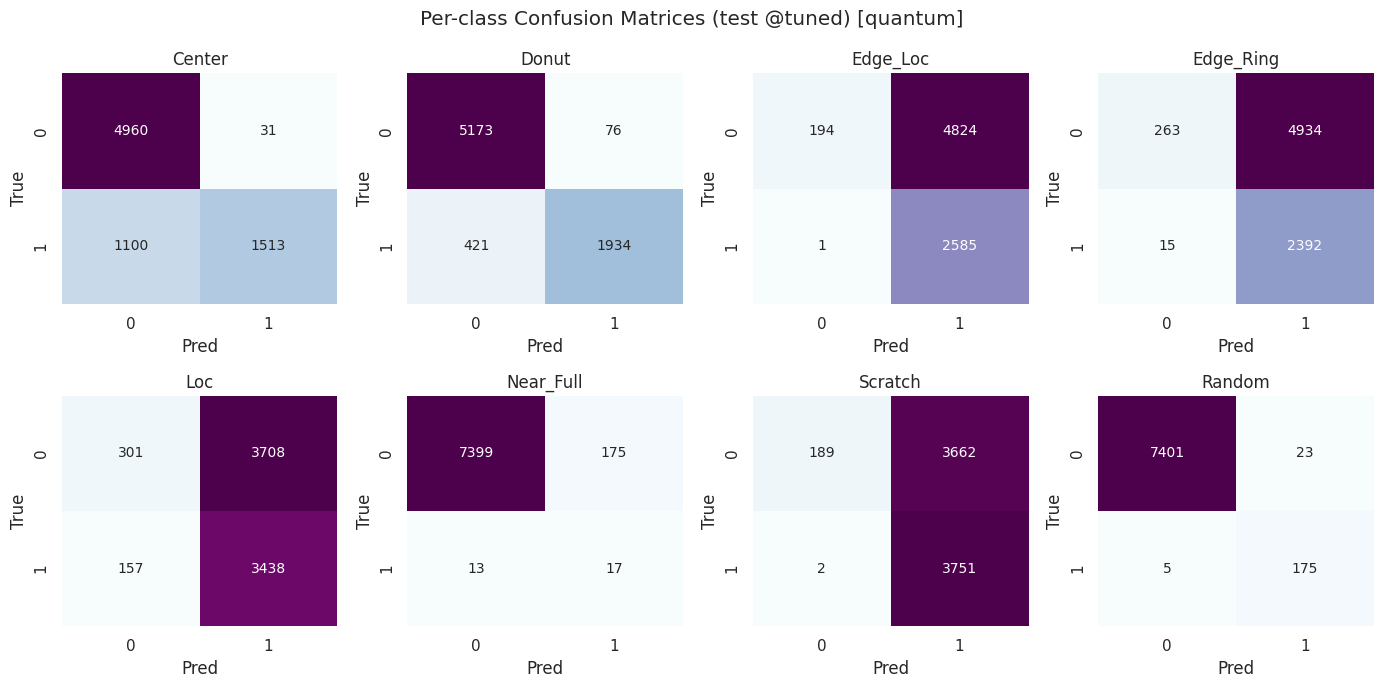

In [19]:
# Confusion matrices
from sklearn.metrics import multilabel_confusion_matrix
mcm = multilabel_confusion_matrix(test_labels, test_preds_tuned)
fig, axes = plt.subplots(2, 4, figsize=(14,7)); axes = axes.ravel()
for i, name in enumerate(LABEL_NAMES):
    tn, fp, fn, tp = mcm[i].ravel()
    cm = np.array([[tn, fp], [fn, tp]])
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", cbar=False, ax=axes[i], annot_kws={"size":10})
    axes[i].set_title(name); axes[i].set_xlabel("Pred"); axes[i].set_ylabel("True")
    axes[i].set_xticklabels(["0","1"]); axes[i].set_yticklabels(["0","1"])
plt.suptitle(f"Per-class Confusion Matrices (test @tuned) [{MODEL_VARIANT}]"); plt.tight_layout(); plt.show()

In [20]:
# Head and total trainable parameters
def count_params(module, trainable_only=True):
    return sum(p.numel() for p in module.parameters() if (p.requires_grad or not trainable_only))

head_params = count_params(getattr(trainer.model, "head", trainer.model.head if hasattr(trainer.model, "head") else trainer.model), True)
total_trainable = sum(p.numel() for p in trainer.model.parameters() if p.requires_grad)
print(f"[{MODEL_VARIANT}] head_params={head_params:,} | total_trainable={total_trainable:,}")

[quantum] head_params=4,164 | total_trainable=4,164


In [21]:
# Measure wall-clock and throughput on val and test
def timed_predict(ds, batch_size=trainer.args.per_device_eval_batch_size):
    torch.cuda.reset_peak_memory_stats() if torch.cuda.is_available() else None
    gc.collect()
    t0 = time.perf_counter()
    out = trainer.predict(ds)
    t1 = time.perf_counter()
    elapsed = t1 - t0
    n = len(ds)
    images_per_sec = n / elapsed if elapsed > 0 else float("nan")
    peak_vram = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0.0
    cpu_mem = psutil.Process(os.getpid()).memory_info().rss / (1024**2)
    return out, {"elapsed_s": elapsed, "ips": images_per_sec, "peak_vram_mb": peak_vram, "cpu_ram_mb": cpu_mem}

val_out, val_time = timed_predict(val_ds)
test_out, test_time = timed_predict(test_ds)
print(f"[{MODEL_VARIANT}] val: {val_time}"); print(f"[{MODEL_VARIANT}] test: {test_time}")

[quantum] val: {'elapsed_s': 22.509212501001457, 'ips': 168.8641928202015, 'peak_vram_mb': 555.130859375, 'cpu_ram_mb': 3360.87109375}
[quantum] test: {'elapsed_s': 45.64968975699958, 'ips': 166.5728735611847, 'peak_vram_mb': 555.37744140625, 'cpu_ram_mb': 3360.87109375}


In [22]:
# Convert logits to probabilities using sigmoid
def sigmoid_np(x): return 1/(1+np.exp(-x))

val_probs_ext = sigmoid_np(val_out.predictions)
test_probs_ext = sigmoid_np(test_out.predictions)
val_labels_ext = val_out.label_ids
test_labels_ext = test_out.label_ids

# Per-class PR-AUC and macro average
per_class_ap = []
for c, name in enumerate(LABEL_NAMES):
    try:
        ap = average_precision_score(test_labels_ext[:,c], test_probs_ext[:,c])
    except Exception:
        ap = float("nan")
    per_class_ap.append(ap)
macro_pr_auc = float(np.nanmean(per_class_ap))
print("Per-class PR-AUC:", {n: round(a,4) for n,a in zip(LABEL_NAMES, per_class_ap)})
print("Macro PR-AUC:", round(macro_pr_auc, 4))

Per-class PR-AUC: {'Center': 0.8135, 'Donut': 0.9588, 'Edge_Loc': 0.3576, 'Edge_Ring': 0.3613, 'Loc': 0.4886, 'Near_Full': 0.0514, 'Scratch': 0.4992, 'Random': 0.9373}
Macro PR-AUC: 0.5585


In [23]:
# Calibration: Brier score (lower is better) and reliability curve data
probs_flat = test_probs_ext.reshape(-1)
labels_flat = test_labels_ext.reshape(-1)
brier = brier_score_loss(labels_flat, probs_flat)
frac_pos, mean_pred = calibration_curve(labels_flat, probs_flat, n_bins=10)
print("Brier score:", round(brier, 6))
calib_points = [{"bin": i+1, "mean_pred": float(mp), "frac_pos": float(fp)} for i,(mp,fp) in enumerate(zip(mean_pred, frac_pos))]

Brier score: 0.171589


In [24]:
# Simple bootstrap CI for macro F1 and macro ROC-AUC on test
from sklearn.metrics import f1_score, roc_auc_score
rng = np.random.default_rng(123)
B = 200
macro_f1_samples, macro_auc_samples = [], []

# Use tuned thresholds if already computed; else default 0.5
th_use = thresholds if 'thresholds' in globals() else np.array([0.5]*len(LABEL_NAMES))
test_pred_tuned_ext = (test_probs_ext >= th_use[None,:]).astype(int)

for _ in range(B):
    idx = rng.integers(0, len(test_labels_ext), size=len(test_labels_ext))
    yb = test_labels_ext[idx]
    pb = test_probs_ext[idx]
    hb = (pb >= th_use[None,:]).astype(int)
    macro_f1_samples.append(f1_score(yb, hb, average="macro", zero_division=0))
    try:
        macro_auc_samples.append(roc_auc_score(yb, pb, average="macro"))
    except Exception:
        macro_auc_samples.append(float("nan"))

def ci(a, alpha=0.05):
    a = np.array(a); a = a[~np.isnan(a)]
    lo, hi = np.percentile(a, [100*alpha/2, 100*(1-alpha/2)]) if len(a)>0 else (float("nan"), float("nan"))
    return float(np.nanmean(a)), float(lo), float(hi)

macro_f1_mean, f1_lo, f1_hi = ci(macro_f1_samples)
macro_auc_mean, auc_lo, auc_hi = ci(macro_auc_samples)
print(f"Bootstrap macro F1 mean={macro_f1_mean:.4f} 95% CI=({f1_lo:.4f},{f1_hi:.4f})")
print(f"Bootstrap macro ROC-AUC mean={macro_auc_mean:.4f} 95% CI=({auc_lo:.4f},{auc_hi:.4f})")

Bootstrap macro F1 mean=0.6268 95% CI=(0.6205,0.6331)
Bootstrap macro ROC-AUC mean=0.7282 95% CI=(0.7218,0.7350)


In [25]:
report = {
    "variant": MODEL_VARIANT,
    "head_params": int(head_params),
    "total_trainable": int(total_trainable),
    "val_timing": val_time,
    "test_timing": test_time,
    "macro_pr_auc": macro_pr_auc,
    "brier_score": float(brier),
    "calibration_points": calib_points,
    "macro_f1_bootstrap_mean": macro_f1_mean,
    "macro_f1_ci95": [f1_lo, f1_hi],
    "macro_auc_bootstrap_mean": macro_auc_mean,
    "macro_auc_ci95": [auc_lo, auc_hi],
}

os.makedirs("bench_reports", exist_ok=True)
path = os.path.join("bench_reports", f"bench_{MODEL_VARIANT}.json")
with open(path, "w") as f:
    json.dump(report, f, indent=2)
print("Saved:", path)

Saved: bench_reports/bench_quantum.json


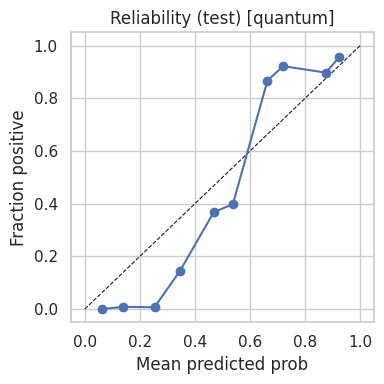

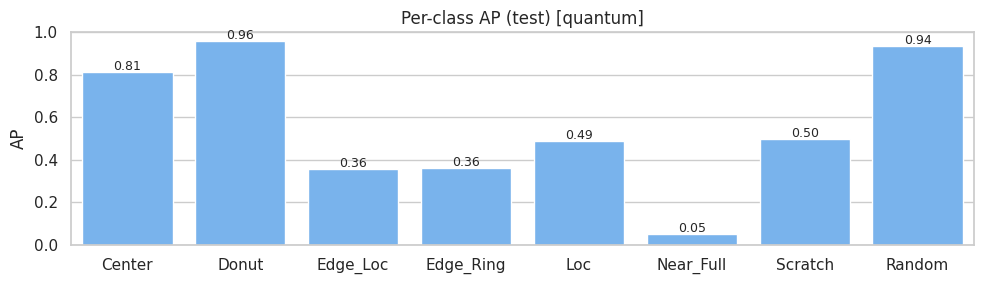

In [26]:
# Reliability diagram
plt.figure(figsize=(4,4))
plt.plot([0,1],[0,1],'k--',linewidth=0.8)
plt.plot([p["mean_pred"] for p in calib_points], [p["frac_pos"] for p in calib_points], marker="o")
plt.xlabel("Mean predicted prob"); plt.ylabel("Fraction positive")
plt.title(f"Reliability (test) [{MODEL_VARIANT}]"); plt.tight_layout(); plt.show()

# Macro PR by averaging per-class precision-recall curves is tricky; show AP bars instead
plt.figure(figsize=(10,3))
vals = [ap if not np.isnan(ap) else 0.0 for ap in per_class_ap]
sns.barplot(x=LABEL_NAMES, y=vals, color="#66b3ff")
plt.ylim(0,1); plt.ylabel("AP"); plt.title(f"Per-class AP (test) [{MODEL_VARIANT}]")
for i,v in enumerate(vals):
    plt.text(i, v+0.01, f"{v:.2f}", ha="center", fontsize=9)
plt.tight_layout(); plt.show()